In [1]:
import tensorflow as tf
import tensorflow.keras.layers as kl
import matplotlib.pyplot as plt




In [2]:
class residual_block(tf.keras.Model):
    def __init__(self, nb_filters1=128, nb_filters2=128):
        super(residual_block, self).__init__()

        self.conv1 = kl.Conv2D(nb_filters1, 3, 1, 'same')
        self.bn1 = kl.BatchNormalization()
        self.acti1 = kl.PReLU(shared_axes=[1, 2])
        self.conv2 = kl.Conv2D(nb_filters2, 3, 1, 'same')
        self.bn2 = kl.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.acti1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        x += input_tensor
        return x



class SRNet(tf.keras.Model):
    def __init__(self):
        super(SRNet, self).__init__()

        self.conv1 = kl.Conv2D(64, 9, 1, 'same')
        self.acti1 = kl.PReLU(shared_axes=[1, 2])

        self.block1 = residual_block(64, 64)
        self.block2 = residual_block(64, 64)
        self.block3 = residual_block(64, 64)
        self.block4 = residual_block(64, 64)

        self.conv2 = kl.Conv2D(64, 3, 1, 'same')
        self.bn = kl.BatchNormalization()

        self.conv3 = kl.Conv2D(256, 3, 1, 'same')
        self.acti3 = kl.PReLU(shared_axes=[1, 2])

        self.conv4 = kl.Conv2D(256, 3, 1, 'same')
        self.acti4 = kl.PReLU(shared_axes=[1, 2])

        self.conv5 = kl.Conv2D(3, 9, 1, 'same')


    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.acti1(x)
        x1 = self.block1(x, training=training)
        x2 = self.block2(x1, training=training) + x
        x3 = self.block3(x2, training=training) + x + x1
        x4 = self.block4(x3, training=training) + x + x1 + x2
        
        y = self.conv2(x4)
        y = self.bn(y, training=training) + x

        y = self.conv3(y)
        y = tf.nn.depth_to_space(y, 2)
        y = self.acti3(y)

        y = self.conv4(y)
        # y = tf.nn.depth_to_space(y, 2)
        y = self.acti4(y)

        return tf.keras.activations.sigmoid(self.conv5(y))


In [3]:
def test_model(model, images):
    images_lr = tf.image.resize(images, (16, 16)).numpy()
    images_hr = model.predict(images_lr)
    for img, img_lr, img_hr in zip(images, images_lr, images_hr):
        fig = plt.figure()
        fig.add_subplot(1, 3, 1)
        plt.imshow(img)
        plt.axis('off')
        fig.add_subplot(1, 3, 2)
        plt.imshow(img_lr)
        plt.axis('off')
        fig.add_subplot(1, 3, 3)
        plt.imshow(img_hr)
        plt.axis('off')
    plt.show()


def sr_plot(model, images):
    images_hr = model.predict(images)
    images_hr = tf.image.adjust_contrast(images_hr, 1.1).numpy()
    images_hr_hr = model.predict(images_hr)
    for img, img_hr, img_hr_hr in zip(images, images_hr, images_hr_hr):
        fig = plt.figure()
        fig.add_subplot(1, 3, 1)
        plt.imshow(img)
        plt.axis('off')
        fig.add_subplot(1, 3, 2)
        plt.imshow(img_hr)
        plt.axis('off')
        fig.add_subplot(1, 3, 3)
        plt.imshow(img_hr_hr)
        plt.axis('off')
    plt.show()



In [4]:
(images, _), (x_test, _) = tf.keras.datasets.cifar100.load_data()
images = images / 255

images_lr = tf.image.resize(images, (16, 16))

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.MeanSquaredError()

model = SRNet()
model.compile(
    optimizer=optimizer,
    loss=loss
)




In [ ]:
model.fit(images_lr, images, batch_size=32, epochs=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

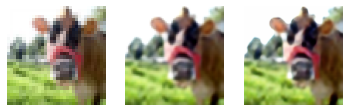

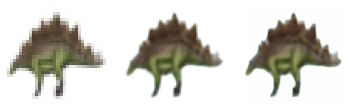

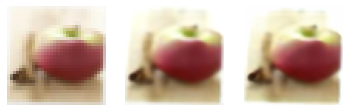

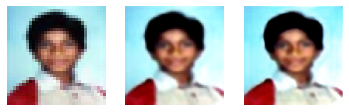

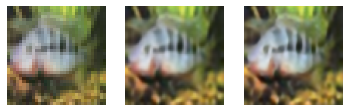

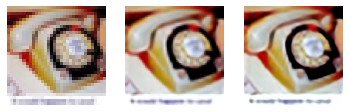

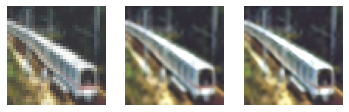

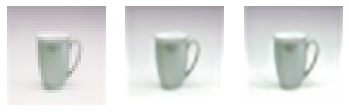

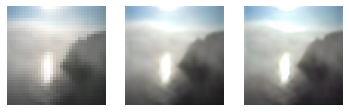

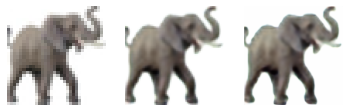

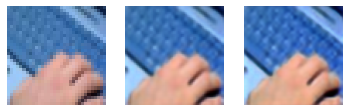

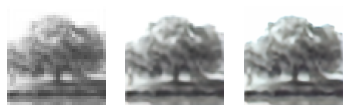

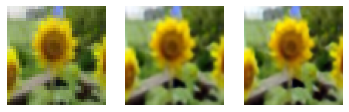

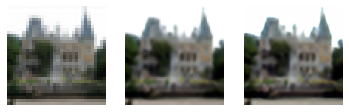

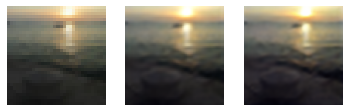

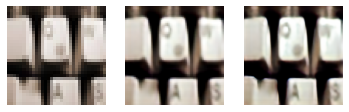

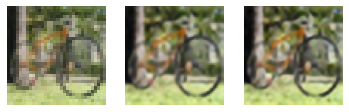

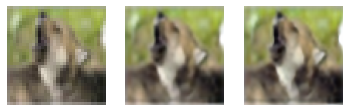

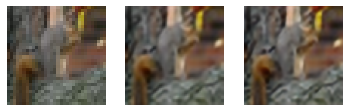

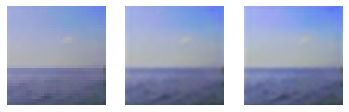

In [ ]:
test_images = images[:20]
# test_model(model, test_images)
sr_plot(model, test_images)


In [ ]:
print(test_images.shape)
model.summary()

(20, 32, 32, 3)
Model: "sr_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  15616     
_________________________________________________________________
p_re_lu (PReLU)              multiple                  16384     
_________________________________________________________________
residual_block (residual_blo multiple                  90752     
_________________________________________________________________
residual_block_1 (residual_b multiple                  90752     
_________________________________________________________________
residual_block_2 (residual_b multiple                  90752     
_________________________________________________________________
residual_block_3 (residual_b multiple                  90752     
_________________________________________________________________
conv2d_9 (Conv2D)            multiple       